In this notebook I try and test different I/O methods to read fits files to load the spectra. I also look for a good way to subsample the spectra.

In [4]:
import numpy as np
import fitsio
from fitsio import FITS, FITSHDR
from astropy.table import Table
import matplotlib.pyplot as plt
import pipeline as io
%matplotlib inline
%load_ext autoreload
%autoreload 2

Comparison of fitsio and astropy.table.Table

In [63]:
%%time 
filename = 'data/spectra1000/spec-4216-55477-0204.fits'
data = np.array(Table.read(filename, hdu=1)['loglam','flux'])
# Astropy unified fits io

CPU times: user 84 ms, sys: 15 µs, total: 84 ms
Wall time: 85.7 ms


In [4]:
%%time
filename = 'data/spectra1000/spec-4216-55477-0234.fits'
data = fitsio.read(filename, columns=['loglam','flux'])
# Fitio input utility

CPU times: user 20.4 ms, sys: 3.39 ms, total: 23.7 ms
Wall time: 33.1 ms


Apparently, the ```fitsio``` library is a little faster. Also, it returns a numpy array directly, rather than a heavy astropy Table

------------------------
Guess: loading the ```loglam``` column is unnecessary because it's always the same array. We need to verify this.

In [17]:
from glob import glob
filelist = glob('data/spectra1000/*.fits')
mins, maxs = [], []            
for file in filelist[:10]: # Loop first 10 files
    lam = fitsio.read(file, ext=1, columns='loglam')
    mins.append(lam.min())
    maxs.append(lam.max())
    print(lam.min(), lam.max(), lam.size)
print('Higher left endoint: {}'.format(max(mins)))
print('Lower right endpoint: {}'.format(min(maxs)))

3.5587 4.0168 4582
3.5522 4.0141 4620
3.5521 4.0148 4628
3.5511 4.0145 4635
3.5522 4.0141 4620
3.5597 4.0163 4567
3.5582 4.0165 4584
3.5517 4.0143 4627
3.5574 4.0153 4580
3.5521 4.0139 4619
Higher left endoint: 3.5597000122070312
Lower right endpoint: 4.013899803161621


Clearly, I was wrong. Every file has its own length and the wavelength limits are not the same

Now let's try downsampling the spectrum (because 4000 points would need too much memory and training will be slow)

3.5520999431610107 4.0137076809202465


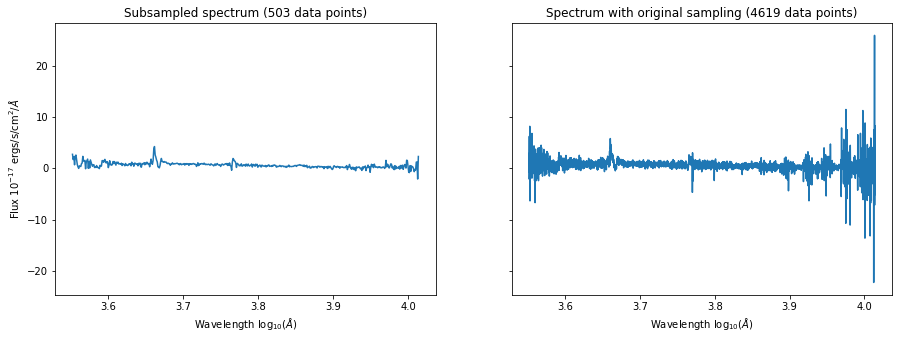

In [13]:
from scipy.signal import resample

data = fitsio.read(filename, ext=1, columns=['loglam','flux'])
# WATCH OUT: The endianness of the arrays must be set to little endian
# before using scipy.signal subsample
loglam = np.asarray(data['loglam'], dtype=np.dtype('<f4'))
flux = np.asarray(data['flux'], dtype=np.dtype('<f4'))

# This is very easy, but behind the scenes is using an
# FFT so I don't know if this will scale reasonably
sub_flux, sub_loglam = resample(flux, 503, t=loglam)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
ax[0].plot(sub_loglam, sub_flux)
ax[1].plot(data['loglam'], data['flux'])
ax[0].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[1].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[0].set_ylabel(r'Flux $10^{-17}$ ergs/s/cm$^2$/$\AA$')
ax[0].set_title(r'Subsampled spectrum (503 data points)')
ax[1].set_title(r'Spectrum with original sampling ({} data points)'.format(len(flux)))
# print(sub_loglam.min(), sub_loglam.max())

As we can see, in the subsampled spectrum the noise is greatly reduced while still showing the main features.
Now, as we saw earlier, the wavelength endopoints do not coincide for every spectrum. Hence, I would wish to standarize the spectra in a single wavelength axis for all of the data. This can be achieved through interpolation.

Execution times: 
Method 1: 1.7147064208984375 milliseconds
Method 2: 0.2701282501220703 milliseconds


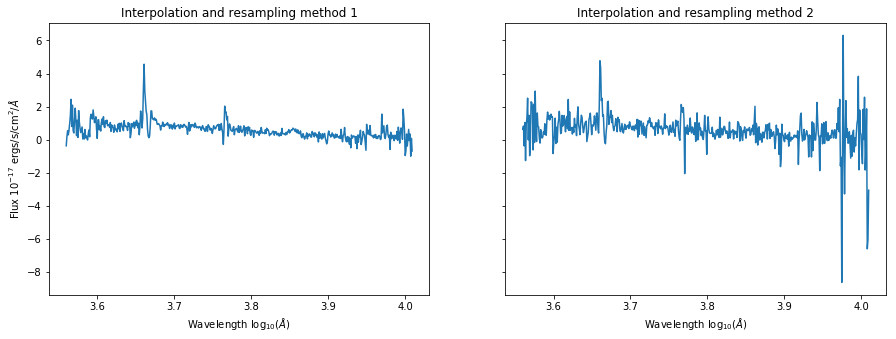

In [33]:
from scipy.interpolate import interp1d
from time import time

# Let's say we want to restrict the spectrum to the interval 3.56-4.01
ispec = interp1d(loglam, flux, kind='cubic')

# Method 1:
start1 = time()
loglam_1_int = np.linspace(3.56, 4.01, len(loglam), endpoint=True)
flux_1_int  = ispec(loglam_1_int)
sub_flux_1_int,  sub_loglam_1_int = resample(flux_1_int, t=loglam_1_int, num=503)
time_taken1 = time() - start1

# Method 2:
start2 = time()
sub_loglam_2_int = np.linspace(3.56, 4.01, 503, endpoint=True)
sub_flux_2_int = ispec(sub_loglam_2_int)
time_taken2 = time() - start2

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2,sharey=True, figsize=(15,5))
ax[0].plot(sub_loglam_1_int, sub_flux_1_int)
ax[1].plot(sub_loglam_2_int, sub_flux_2_int)
ax[0].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[1].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[0].set_ylabel(r'Flux $10^{-17}$ ergs/s/cm$^2$/$\AA$')
ax[0].set_title('Interpolation and resampling method 1')
ax[1].set_title('Interpolation and resampling method 2');
print('Execution times: ')
print('Method 1: {} milliseconds'.format(time_taken1 * 1e3))
print('Method 2: {} milliseconds'.format(time_taken2 * 1e3))

Here we have two choices:
1. Interpolating  with the same number of points and then resampling afterwards
2. Interpolating and resampling directly with ```interp1d```


While the second one may seem quicker, the first may be more robust. For this reason, I finally implemented the first method wrapped in a utility function in the ```pipeline.py``` module

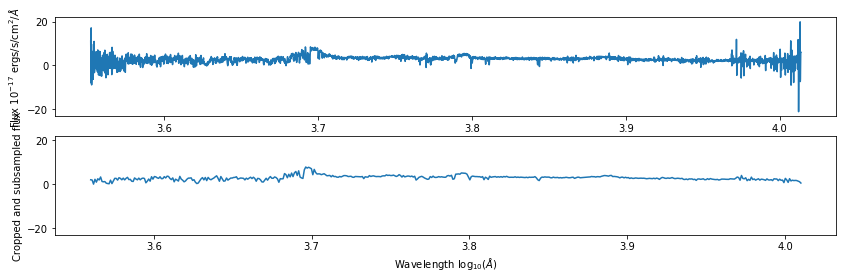

In [3]:
# %autoreload 2
import pipeline as io
spec = fitsio.read('data/spectra1000/spec-4216-55477-0210.fits', columns=['flux', 'loglam'], dtype=np.float32)
reduced_spec = io.crop_and_subsample(spec, 503, (3.56, 4.01))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 4), sharey=True)
ax[0].plot(spec['loglam'], spec['flux'])
ax[1].plot(np.linspace(3.56, 4.01, 503, endpoint=True), reduced_spec)
ax[1].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[0].set_ylabel(r'Flux $10^{-17}$ ergs/s/cm$^2$/$\AA$')
ax[1].set_ylabel(r'Cropped and subsampled flux');


-------
The next thing to incorporate to the pipeline is the renormalization. Following [Busca (2018)](https://arxiv.org/abs/1808.09955):
>Large variations in the
inputs to neural networks, in our case due to the distribution
of quasar luminosity, are known to slow down learning. To
reduce this problem we renormalize spectra by subtracting
to each flux its weighted mean and dividing the result by
its weighted root-mean-square, using the inverse variances
available with each spectrum as weights.

I interpret this as the the following. If $f_i$ is the $i-$th flux point and $1/\sigma_i^2$ it's corresponding inverse variance, then the renormalized flux $f_i^{\prime}$ is 


In [64]:
%%latex
\begin{equation}
 f_i^{\prime} = \frac{f_i(1 - 1/\sigma_i^2)}{\sqrt{\sum_{j}{\frac{f_i^2}{\sigma_j^2}}}}
\end{equation}

<IPython.core.display.Latex object>

Of course, this has to be done before resampling

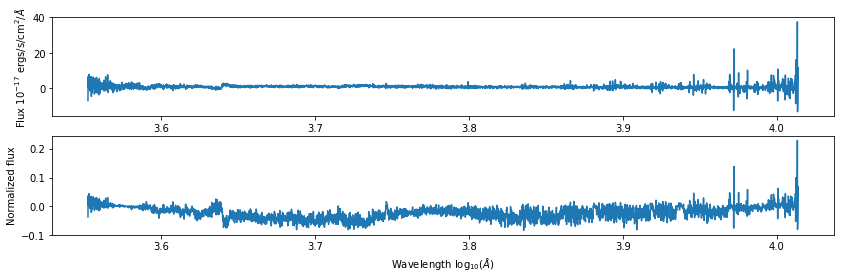

In [2]:
data = fitsio.read('data/spectra1000/spec-4216-55477-0202.fits', columns=['loglam', 'flux', 'ivar'], dtype=np.float32)
normflux = (data['flux'] - data['flux'] * data['ivar']) / np.sqrt(np.sum(data['ivar'] * data['flux'] ** 2))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 4))
ax[0].plot(data['loglam'], data['flux'])
ax[1].plot(data['loglam'], normflux)
ax[1].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[0].set_ylabel(r'Flux $10^{-17}$ ergs/s/cm$^2$/$\AA$')
ax[1].set_ylabel(r'Normalized flux v.1');

This doesn't look good. The normalization seems to produce a noisier spectrum and worse is that __emission lines were turned into absorption lines!!__   
  A possible fix is to just invert the overall sign...

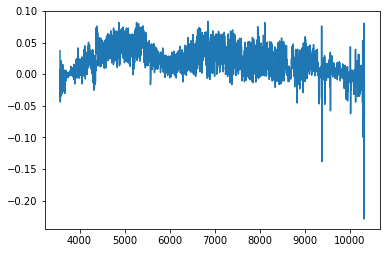

In [3]:
plt.plot(data['loglam'], -normflux)

This is still not satisfactory, so taking a quick glance at the [QuasarNET code](https://github.com/ngbusca/QuasarNET/blob/master/py/quasarnet/io.py) I found they were doing something like this:

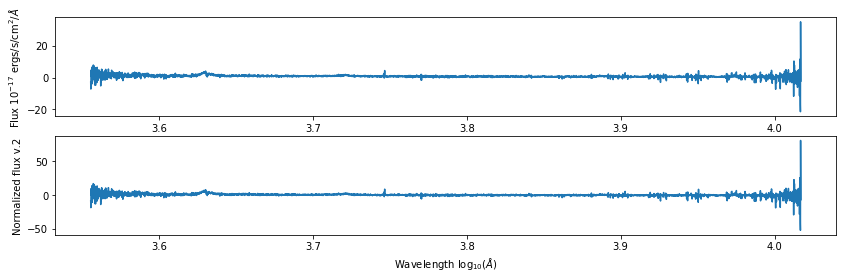

In [6]:
data = fitsio.read('data/spectra1000/spec-4296-55499-0684.fits', columns=['loglam', 'flux', 'ivar'], dtype=np.float32)

mdata = np.average(data['flux'], weights = data['ivar'])
sdata = np.average((data['flux'] - mdata) ** 2, weights = data['ivar'])
sdata = np.sqrt(sdata)

# This is for removing points with zero flux 
w = sdata == 0
data['flux'] = data['flux'][~w]
mdata = mdata[~w]
sdata = sdata[~w]
# -------------------------------------------
normflux = data['flux'] - mdata
normflux /= sdata


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 4))
ax[0].plot(data['loglam'], data['flux'])
ax[1].plot(data['loglam'], normflux)
ax[1].set_xlabel(r'Wavelength $\log_{10}(\AA)$')
ax[0].set_ylabel(r'Flux $10^{-17}$ ergs/s/cm$^2$/$\AA$')
ax[1].set_ylabel(r'Normalized flux v.2');

Ahh this looks much better!

## Alternative normalization

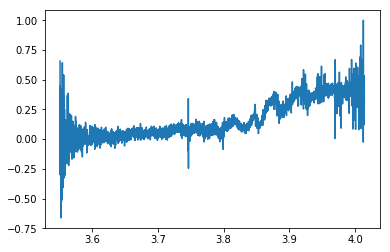

In [10]:
data = fitsio.read('data/starboss/spec-3586-55181-0071.fits', columns=['loglam', 'flux', 'ivar'], dtype=np.float32)

normflux = data['flux'] / data['flux'].max()
plt.plot(data['loglam'], normflux)

This is easier and faster, so I'll stick with this method as the default by now.

-----
### Truth vector retrieval

We would need to produce a truth vector for every source, indicating wether the source is a quasar or not. Luckily, the [DR14Q catalog](https://www.sdss.org/dr14/algorithms/qso_catalog/) "only contains secure identifications (i.e. QSO and QSO_BAL)". This means we only have two quasar classes. 

In [30]:
# The hash function to produce the specObjid number was implemented in the pipeline.py file
import pipeline as io
print(io.hash_specid(266,51602,1,26))
print(299489676975171584)  #Taken from DR15:dbo.fSpecidFromSDSS

299489676975171584
299489676975171584


Both numbers are equal. We now construct a file containing all SpecObjIDs of DR14Q objects, to later build or truth lookup table

In [6]:
def run2d_from_spectro(spectro):
    if spectro == 'BOSS':
        return 'v5_10_0'
    elif spectro == 'SDSS':
        return 26


dr14q = Table.read('data/DR14Q_v4_4.fits')
with open('data/dr14q_specids.txt', 'w') as outfile:
    for i, qso in enumerate(dr14q):
        specid = io.hash_specid(qso['PLATE'], qso['MJD'], qso['FIBERID'], run2d_from_spectro(qso['SPECTRO']))
        outfile.write('{:d}\n'.format(specid))
        
# This file will contain all specObjIDs from the DR14Q catalog

In [28]:
!tail data/dr14q_specids.txt 

8836077429061558272
6926539628846489600
8631380805938028544
6960417781557731328
8631184543112470528
7330985091827474432
8044620915265216512
9841507702370443264
8551281102567743488
8044626962579169280


In [25]:
KNOWN_QSOS = np.loadtxt('data/dr14q_specids.txt', dtype=np.uint64)

In [31]:
%%time
9841507702370442264 in known_qsos

CPU times: user 977 µs, sys: 44 µs, total: 1.02 ms
Wall time: 674 µs


False

There is no need to repeat this process for BOSS stars, because the ```dr15stars_boss_masolimano.csv``` file includes SpecObjIDs

In [35]:
!head data/dr15stars_boss_masolimano.csv

specObjID,plate,mjd,fiberID,run2d,ra,dec,z_person
4106383557412233216,3647,55827,824,v5_10_0,37.505807,1.2179885,0
4110668344494891008,3651,55247,28,v5_10_0,42.335238,-0.26853344,0
4110672192785588224,3651,55247,42,v5_10_0,41.761256,-1.2088444,0
4110672742541402112,3651,55247,44,v5_10_0,41.809844,-1.2265011,0
4110675766198378496,3651,55247,55,v5_10_0,41.864476,-0.76784226,0
4110678240099540992,3651,55247,64,v5_10_0,42.142978,-0.31044313,0
4110679889366982656,3651,55247,70,v5_10_0,42.259116,-0.17256063,0
4110687036192563200,3651,55247,96,v5_10_0,42.025064,-0.070037997,0
4110688960337911808,3651,55247,103,v5_10_0,41.584526,-1.055747,0


In [38]:
KNOWN_STARS = np.loadtxt('data/dr15stars_boss_types.csv', dtype=np.uint64, delimiter=',', skiprows=1, usecols=0)

In [39]:
%%time
4110687036192563200 in known_stars

CPU times: user 808 µs, sys: 37 µs, total: 845 µs
Wall time: 466 µs


True

In [43]:
all_specids = np.concatenate([known_qsos, known_stars])
np.savetxt('data/all_specids.txt', all_specids, fmt='%i')

In [78]:
from pipeline import hash_specid
def tell_the_truth(filename):
    """ Return the truth vector for a given spectrum filename.
    Constants KNOWN_QSOS and KNOWN_STARS must be loaded in memory.
    parameters:
        -filename: str, the path to the spectrum fits file
    return:
        -truth: array, [qso_prob, redshift]
    
    TODO: Implement redshift  retrieval from fits file or specobjid
    """
    header = fitsio.read_header(filename)
    spec4numbers = (header['PLATEID'], header['MJD'], header['FIBERID'], header['RUN2D'].strip())
    specid = hash_specid(*spec4numbers)  # Compute specobjid hash 
    
    if specid in KNOWN_QSOS:
        return np.array([1., 0.])
    
    elif specid in KNOWN_STARS:
        return np.array([0., 0.])
    
    else:
        return None
tell_the_truth('data/spectra1000/spec-4216-55477-0202.fits')

# Final implementation can be found on the pipeline.py module

array([1., 0.])

In [23]:
from astropy.io import fits
import os
import tempfile
import shutil

In [30]:
def shrink_spectra(filepath):
    """
    Remove unnecesary data from the spectral FITS file. All
    the data needed is contained in the header and the
    flux, loglam and ivar columns. This function
    trims the original fits file and saves the lightweight
    version in a {parent}_ultralight folder. Then deletes the original
    file.
    """
    pathlist = filepath.split('/')
    newpath = '{}_ultralight/{}'.format('/'.join(pathlist[:-1]), pathlist[-1])
    
    temp = tempfile.NamedTemporaryFile(delete=False)
    with fits.open(filepath) as hdul:
        relevant_cols = hdul[1].data.columns[:3]
        hdul[1].data = hdul[1].data.from_columns(relevant_cols)
        hdul = hdul[:2]
        hdul.writeto(temp)
        
    os.remove(filepath)
    print('Removed ' + filepath)
    shutil.move(temp.name, newpath)
    print('Created ' + newpath)
    temp.close()

# from glob  import glob
# filelist = glob('data/spectra1000/*.fits')
# for spec in filelist:
#     shrink_spectra(spec)
# !ls data/spectra1000_ultralight/
spt = Table.read('data/spectra1000_ultralight/spec-4216-55477-0202.fits')
!du -h data/spectra1000_ultralight/

67M	data/spectra1000_ultralight/


The size of the data reduced from about 1.5 GB to 67 MB!!! I shall refactor this code into the pipeline

In [57]:
!grep -n $(tail -n 3 data/star-lite/wget.log | head -n 1 |  awk -F "/" '{print $NF}') data/star_filelist.txt

grep: ..........: No such file or directory
grep: ..........: No such file or directory
grep: ..........: No such file or directory
grep: ..........: No such file or directory
grep: ..........: No such file or directory
grep: 70%: No such file or directory
grep: 301K: No such file or directory
grep: 0s: No such file or directory


Draft  and testbed of ``shrink_star.py`` script:

In [1]:
import pipeline as io
from glob import glob

filelist = glob('data/stars100/*.fits')

for filename in filelist:
    io.shrink_spectra(filename, delete=True)


Removed data/stars100/spec-3656-55241-0914.fits
Created data/stars100_ultralight/spec-3656-55241-0914.fits
Removed data/stars100/spec-3656-55241-0918.fits
Created data/stars100_ultralight/spec-3656-55241-0918.fits
Removed data/stars100/spec-3656-55241-0772.fits
Created data/stars100_ultralight/spec-3656-55241-0772.fits
Removed data/stars100/spec-3656-55241-0746.fits
Created data/stars100_ultralight/spec-3656-55241-0746.fits
Removed data/stars100/spec-3651-55247-0042.fits
Created data/stars100_ultralight/spec-3651-55247-0042.fits
Removed data/stars100/spec-3656-55241-0704.fits
Created data/stars100_ultralight/spec-3656-55241-0704.fits
Removed data/stars100/spec-3656-55241-0767.fits
Created data/stars100_ultralight/spec-3656-55241-0767.fits
Removed data/stars100/spec-3656-55241-0936.fits
Created data/stars100_ultralight/spec-3656-55241-0936.fits
Removed data/stars100/spec-3651-55247-0028.fits
Created data/stars100_ultralight/spec-3651-55247-0028.fits
Removed data/stars100/spec-3651-55247

In [37]:
!ls data/star-lite |wc -l

318956


Some file processing went wrong with the ``shrink_star.py`` script, because of an annoying ``TypeError: buffer is too small for the requested array``

In [13]:
with open('downloaded.txt', 'r') as d:
    with open('total.txt', 'r') as t:
        downs = d.readlines()
        total = t.readlines()
        targets = []
        for spec  in total:
            if spec not in downs:
                targets.append(spec)

print(len(targets))

with open('targets.txt', 'w') as tfile:
    for row in targets:
        tfile.write(row)

In [42]:
def shrink_spectra2(filepath, delete_source=False):
    """
    Remove unnecesary data from the spectral FITS file. All
    the data needed is contained in the header and the
    flux, loglam and ivar columns. This function
    trims the original fits file and saves the lightweight
    version in a {parent}_ultralight folder. Then deletes the original
    file.
    """
    pathlist = filepath.split('/')
    ultralight_parent  = '{}_ultralight'.format('/'.join(pathlist[:-1]))
    
    # Check if the target directory exists
    if not os.path.exists(ultralight_parent):
        os.mkdir(ultralight_parent)
    
    newpath = '/'.join([ultralight_parent, pathlist[-1]])
    
    temp = tempfile.NamedTemporaryFile(delete=False)
    with fits.open(filepath) as hdul:
        out_hdul = hdul.copy()
        relevant_cols = hdul[1].data.columns[:3]
        out_hdul[1].data = hdul[1].data.from_columns(relevant_cols)
        out_hdul = hdul[:2]
        out_hdul.writeto(temp)
        
    temp.close()

io.shrink_spectra('data/star-lite/spec-6022-56076-0256.fits')

Created data/star-lite_ultralight/spec-6022-56076-0256.fits


In [44]:
%%time
filelist = glob('data/star-lite_ultralight/*.fits')
for file in filelist:
    spec = fitsio.read(file, columns=['loglam', 'flux', 'ivar'])

CPU times: user 3min 11s, sys: 31.7 s, total: 3min 43s
Wall time: 4min 59s


In [38]:
!cat downloaded.txt | wc -l

207448


In [5]:
io.shrink_spectra('data/buggy_star/spec-3959-55679-0294.fits')

data/buggy_star/spec-3959-55679-0294.fits is defective, not processed


Estimate how much memory will be necessary to hold the whole preprocessed dataset

In [2]:
# First, the total number of individual spectra
total_stars = !cat data/dr15stars_boss_masolimano.csv | wc -l
total_qsos = !cat data/filelist_boss_qsos.txt | wc -l
total = int(total_qsos[0]) + int(total_stars[0])

# Assume the spectra were reduced to 443 samples and each point has 32 bit precission (i.e 4 bytes)
datapoints = total * 444 # +1 because the class is also included
total_bytes = 4 * datapoints
print('Approximately {:.2f} GB'.format(total_bytes / 1e9))
print(int(total_qsos[0]) - 195171)

Approximately 1.36 GB
251698


Good news! I can fit the entire dataset in RAM :)

In [10]:
import h5py
import numpy as np
from keras.utils import to_categorical

with h5py.File('data/reduced_starboss.h5', 'r') as sb:
    starx = np.array(sb['fluxes']).reshape((318954, 433, 1))
    stary = to_categorical(np.array(sb['classes']))
print(starx.shape, stary.shape)

(318954, 433, 1) (318954, 2)


Time has come to refactor the pipeline code. I want to construct a single lookup table dictionary for class retrieval from SpecObjID:

In [2]:
import json

with open('data/stellar_classes.json', 'r') as j:
    clas = json.load(j)

with open('data/dr14q_specids.txt') as dr14q:
    for line in dr14q:
        specid = line.strip()
        clas[specid] = 'QSO'

with open('data/class_lookup.json', 'w') as lookup:
    json.dump(clas, lookup, indent=4)

Now that I have downloaded a set of galaxy spectra, I must update the dataset HDF5 file and the lookup table. As running preprocess.py all over again will be too slow, I'll load the dataset to memory and add the new data in place

In [12]:
#shrink filesizes
from glob import glob
filelist = glob('data/gal-lite/*.fits')
for filename in filelist:
    io.shrink_spectra(filename)

!mv data/gal-lite_ultralight data/galboss

Created data/gal-lite_ultralight/spec-6043-56096-0848.fits
Created data/gal-lite_ultralight/spec-5129-55864-0770.fits
Created data/gal-lite_ultralight/spec-3662-55182-0200.fits
Created data/gal-lite_ultralight/spec-4266-55486-0258.fits
Created data/gal-lite_ultralight/spec-5173-56046-0475.fits
Created data/gal-lite_ultralight/spec-6757-56416-0494.fits
Created data/gal-lite_ultralight/spec-4550-55894-0412.fits
Created data/gal-lite_ultralight/spec-4853-55928-0796.fits
Created data/gal-lite_ultralight/spec-7396-56809-0934.fits
Created data/gal-lite_ultralight/spec-6396-56358-0238.fits
Created data/gal-lite_ultralight/spec-4658-55592-0576.fits
Created data/gal-lite_ultralight/spec-4192-55469-0242.fits
Created data/gal-lite_ultralight/spec-3809-55533-0160.fits
Created data/gal-lite_ultralight/spec-7282-56660-0600.fits
Created data/gal-lite_ultralight/spec-5192-56066-0470.fits
Created data/gal-lite_ultralight/spec-7334-56656-0129.fits
Created data/gal-lite_ultralight/spec-6681-56419-0808.fi

In [18]:
# Update lookup and perform data reduction
import h5py
from keras.utils import to_categorical

with h5py.File('data/dataset765755_433t_12c.h5', 'r') as ds:
    fluxes = ds['fluxes'][:]
    classes = ds['classes'][:]

classes = np.argmax(classes, axis=1)
classes = to_categorical(classes, num_classes=13)

galfluxes = np.zeros((22795, 433))

fileglob = glob('data/galboss/*.fits')

galookup = dict()
count = 0
for filename in fileglob:
    try:
        hdr = fitsio.read_header(filename)
        specid = str(io.hash_specid(hdr['PLATEID'],
                                hdr['MJD'], 
                                hdr['FIBERID'], 'v5_10_0'))
        galookup[specid] = 'GAL'
        x, _ = io.load_1d_spectrum(filename, galookup, sampling=433)

        # If there are no NaN values, proceed
        if not np.any(np.isnan(x)):
            galfluxes[count,...] = x
            count += 1

    except ValueError:
        # I forgot the actual bug behind this :c
        print(filename + ' caused problems')

    except OSError:
        # Apparently fitsio cannot find some files
        print('Fitsio failed to open ' + filename)

#     if count % 10 == 0:
#         print('Processed  {} files so far'.format(count))

# Crop trailing empty rows

galfluxes = galfluxes[:count,...]
galclasses = to_categorical(np.ones(galfluxes.shape[0]) * 12)

fluxes = np.vstack([fluxes, galfluxes])
classes = np.vstack([classes, galclasses])

with h5py.File('data/dataset{}_433t_13c.h5'.format(fluxes.shape[0]), 'w') as db:
    X = db.create_dataset('fluxes', shape=fluxes.shape, dtype='f4')
    Y = db.create_dataset('classes', shape=classes.shape, dtype='f4')
    X[:] = fluxes
    Y[:] = classes
print('Done with {} files'.format(count))

/home/manuel/mqc/pipeline.py:50: RuntimeWarning: invalid value encountered in true_divide
  normspec['flux'] = spectrum['flux'] / spectrum['flux'].max()


Done with 22784 files


In [19]:
# Add new keypairs to lookup json
import json
with open('data/class_lookup.json', 'r') as dic:
    lookup = json.load(dic)
for specid in galookup:
    lookup[specid] = galookup[specid]

with open('data/class_lookup.json', 'w') as kek:
    json.dump(lookup, kek, indent=4)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
      dtype=float32)